Next steps:
* Calculate threhold based on OOF predictions, 
* Make a system for prediction from all training folds, 
* Including TTA in the predictions

In [1]:
import pickle
import os
import gc
import cv2
import math
import copy
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import joblib
from tqdm import tqdm
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import albumentations as A
from albumentations.pytorch import ToTensorV2
import warnings
warnings.filterwarnings("ignore")
# import sys
# sys.path.append("../input/timm-pytorch-image-models")
import timm
import seaborn as sns

In [2]:
CONFIG = {"seed": 21, # choose your lucky seed
          "img_size": 768, # training image size
          "model_name": "tf_efficientnet_b0", # training model arhitecture
          "num_classes": 15587, # total individuals in training data
          "test_batch_size": 64, # choose acording to the training arhitecture and image size 
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), # gpu
          "test_mode":False, # selects just the first 200 samples from the test data, usefull for debuging purposes
          "threshold":0.1,
          "neigh":5
          }

In [3]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [4]:
def get_test_file_path(id):
    return f"{TEST_DIR}/{id}"

def get_train_file_path(id):
    return f"{TRAIN_DIR}/{id}"

ROOT_DIR = '../data/happy-whale-and-dolphin/'
TEST_DIR = '../data/happy-whale-and-dolphin/test_images'
TRAIN_DIR = '../data/happy-whale-and-dolphin/train_images'
weights_path = "./Loss14.8786_epoch33.pth"

if CONFIG["test_mode"]==True:
    df_test = pd.read_csv(f"{ROOT_DIR}/sample_submission.csv")[:200]
    df_train = pd.read_csv(f"{ROOT_DIR}/train.csv")[:200]
else:
    df_test = pd.read_csv(f"{ROOT_DIR}/sample_submission.csv")
    df_train = pd.read_csv(f"{ROOT_DIR}/train.csv")  


df_test['file_path'] = df_test['image'].apply(get_test_file_path)
df_train['file_path'] = df_train['image'].apply(get_train_file_path)

In [5]:
class HappyWhaleDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img
        }

In [6]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

In [7]:
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, 
                 m=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device=CONFIG['device'])
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) ------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

In [8]:
class HappyWhaleModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super(HappyWhaleModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.fc = nn.Linear(in_features,512)

    def forward(self, images):
#        print("images: ", images.size())
#        print("labels: ", labels.size())
        features = self.model(images)
#        print("features: ", features.size())
        pooled_features = self.pooling(features).flatten(1)
#        print("pooled_features: ", pooled_features.size())
        output = self.fc(pooled_features)
#        print("output: ", output.size())
        return output

In [9]:
data_transforms = {
    "test": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
    
}

In [10]:
def inference(model, dataloader, device):
    model.eval()  
    outputList=[]
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        with torch.no_grad():
            images = data['image'].to(device, dtype=torch.float)
            batch_size = images.size(0)
            outputs = model(images)
            outputList.extend(outputs.cpu().detach().numpy())
    return outputList

In [11]:
model = HappyWhaleModel(CONFIG['model_name'])
model.to(CONFIG['device']);
model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [12]:
#predict first on train dataset to extract embeddings
train_dataset = HappyWhaleDataset(df_train, transforms=data_transforms["test"])
train_loader = DataLoader(train_dataset, batch_size=CONFIG['test_batch_size'], 
                          num_workers=8, shuffle=False, pin_memory=True)

test_dataset = HappyWhaleDataset(df_test, transforms=data_transforms["test"])
test_loader = DataLoader(test_dataset, batch_size=CONFIG['test_batch_size'], 
                          num_workers=8, shuffle=False, pin_memory=True)

In [13]:
df_train.head()

,image,species,individual_id,file_path
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,../data/happy-whale-and-dolphin/train_images/0...
1,000562241d384d.jpg,humpback_whale,1a71fbb72250,../data/happy-whale-and-dolphin/train_images/0...
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b,../data/happy-whale-and-dolphin/train_images/0...
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063,../data/happy-whale-and-dolphin/train_images/0...
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392,../data/happy-whale-and-dolphin/train_images/0...


In [14]:
train_predictions = inference(model, train_loader, CONFIG['device'])

100%|██████████| 798/798 [07:30<00:00,  1.77it/s]


In [15]:
train_labels = df_train['individual_id'].values

In [16]:
encoder = LabelEncoder()
encodedLabels = encoder.fit_transform(train_labels)

In [17]:
len(train_predictions)

51033

In [18]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=CONFIG['neigh'],metric='cosine')
neigh.fit(train_predictions, encodedLabels)

KNeighborsClassifier(metric='cosine')

In [19]:
test_predictions =  inference(model, test_loader, CONFIG['device'])

100%|██████████| 437/437 [04:07<00:00,  1.76it/s]


In [20]:
raw_predictions = neigh.predict_proba(test_predictions)

thres established to 0.0


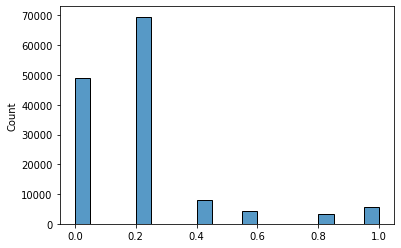

In [21]:
allPredictionsConfidences = []
df = pd.read_csv(f"{ROOT_DIR}/sample_submission.csv")
for i in range(len(raw_predictions)):
    predictTop = raw_predictions[i].argsort()[-5:][::-1]
    topValues = [raw_predictions[i][k] for k in predictTop]
    allPredictionsConfidences.extend(topValues)
sns.histplot(data=allPredictionsConfidences, bins=20)
#naive threhold calculated by 5 percentile (we consider than 5% of the data are from unknown individuals)
thres = np.percentile(allPredictionsConfidences, 5)
print("thres established to",thres)
CONFIG['threshold'] = thres

In [22]:
predictTopDecoded = {}
df = pd.read_csv(f"{ROOT_DIR}/sample_submission.csv")
for i in range(len(raw_predictions)):
    predictTop = raw_predictions[i].argsort()[-5:][::-1]
    topValues = [raw_predictions[i][k] for k in predictTop]
    if topValues[0] <= CONFIG['threshold']:
        tempList=encoder.inverse_transform(predictTop[:4])

        tempList=['new_individual',tempList[0],tempList[1],tempList[2],tempList[3]]

        predictTopDecoded[df.iloc[i]['image']] = tempList    
        
    elif topValues[1] <= CONFIG['threshold']:
        tempList=encoder.inverse_transform(predictTop[:4])

        tempList=[tempList[0],'new_individual',tempList[1],tempList[2],tempList[3]]

        predictTopDecoded[df.iloc[i]['image']] = tempList
        
    elif topValues[2] <= CONFIG['threshold']:
        tempList=encoder.inverse_transform(predictTop[:4])

        tempList=[tempList[0],tempList[1],'new_individual',tempList[2],tempList[3]]

        predictTopDecoded[df.iloc[i]['image']] = tempList
        
    elif topValues[3] <= CONFIG['threshold']:
        tempList=encoder.inverse_transform(predictTop[:4])

        tempList=[tempList[0],tempList[1],tempList[2],'new_individual',tempList[3]]

        predictTopDecoded[df.iloc[i]['image']] = tempList 
        
    elif topValues[4] <= CONFIG['threshold']:
        tempList=encoder.inverse_transform(predictTop[:4])

        tempList=[tempList[0],tempList[1],tempList[2],tempList[3],'new_individual']

        predictTopDecoded[df.iloc[i]['image']] = tempList       
        
    else:
        predictTopDecoded[df.iloc[i]['image']] = encoder.inverse_transform(predictTop)
    
        
for x in tqdm(predictTopDecoded):
    predictTopDecoded[x] = ' '.join(predictTopDecoded[x])

100%|██████████| 27956/27956 [00:00<00:00, 1525995.43it/s]


In [23]:
predictions = pd.Series(predictTopDecoded).reset_index()
predictions.columns = ['image','predictions']
predictions.to_csv('submission.csv',index=False)
predictions.head()

,image,predictions
0,000110707af0ba.jpg,fbe2b15b5481 398bc836ee35 c4deab707116 new_ind...
1,0006287ec424cb.jpg,8f67f9930eb6 b2e5eac3bfba 13bfe4e2583b d842ff8...
2,000809ecb2ccad.jpg,44ba380d5bfa c80653b9edd0 cb0fed574200 263b0ea...
3,00098d1376dab2.jpg,6ad3713dda3a new_individual ffff6255f559 5560c...
4,000b8d89c738bd.jpg,ef2bf7f7553d 77b058712faf aabd3432117a 079981f...
